# Calculating Option Price using Garman–Kohlhagen for Foreign Exchange Options

Garman–Kohlhagen is a options pricing model specifically made for FX. Utilzing a similar composition to Black Scholes, we calculate the price of an option through the underlying's spot price, risk free rate (both domestically and foreign), time to maturity, and volatility. I have taken the equations that Garman Kohlhagen has done, and put them into Python.

## Imports

In [184]:
# Importing Packages
import math
import json
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas_datareader as reader
from scipy.optimize import minimize
from datetime import datetime, date
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter1d

### Garman–Kohlhagen Equations

![GKequation.png](GKequation.png)

### Garman–Kohlhagen Helper Functions

In [185]:
# S is the current spot rate
# K is the strike price
# T is the time to maturity (calculated according to the appropriate day count convention) 
# rd is domestic risk free simple interest rate
# rf is foreign risk free simple interest rate
# sigma is the volatility of the FX rate
# flag 'c' or 'p' for call or put

# Calcuating d1 of Black Scholes Equation
def d1(S, K, T, rd, rf, sigma):
    return ((np.log(S / K) + (rd - rf + (sigma ** 2) / 2) * T)) / (sigma * np.sqrt(T))

# Calcuating d2 of Black Scholes Equation
def d2(S, K, T, rd, rf, sigma):
    return d1(S, K, T, rd, rf, sigma) - sigma * np.sqrt(T)
       
# Call Option Black Scholes Equation
def gkc(S, K, T, rd, rf, sigma):
    return S * norm.cdf(d1(S, K, T, rd, rf, sigma)) - K * math.exp(-rd * T) * norm.cdf(d2(S, K, T, rd, rf, sigma))

# Put Option Black Scholes Equation
def gkp(S, K, T, rd, rf, sigma):
    return K * math.exp(-rd * T) * norm.cdf(-1 * d2(S, K, T, rd, rf, sigma)) - S * math.exp(-rf * T) * norm.cdf(-1 * d1(S, K, T, rd, rf, sigma))

### Garman–Kohlhagen Function

In [186]:
# GK FX Exchange Option's Pricing Model
def garman_kohlhagen(S, K, T, rd, rf, sigma, flag = "c"):
    if flag == "c":
        price = gkc(S, K, T, rd, rf, sigma)
        
    elif flag == "p":
        price = gkp(S, K, T, rd, rf, sigma)
        
    else:
        raise ValueError("Invalid option type. Either 'c' or 'p' for call or put.")

    return price

### Gathering Historical Data on Underlying Currency

In [187]:
# DEXUSEU is U.S. Dollars to Euro Spot Exchange Rate
expiry = '02-23-2024'
strike = 1.1170

# Pulling FX Exchange data from Federal Reserve Bank of St. Louis
exchange_rate = reader.DataReader('DEXUSEU', 'fred')

# Renaming Column, and dropping NA rows
exchange_rate = exchange_rate.dropna()

# Calculating, Adding Previous Closing Price Column & Daily Returns
exchange_rate = exchange_rate.assign(Previous = exchange_rate.DEXUSEU.shift(1))
exchange_rate['Returns'] = ((exchange_rate.DEXUSEU - exchange_rate.Previous) / exchange_rate.Previous)

# Renaming column to EUR/USD
exchange_rate.rename(columns={'DEXUSEU': 'EUR/USD'}, inplace=True)

# Calculating Volatility from historical data
sigma = np.sqrt(252) * exchange_rate['Returns'].std() 

# Pulling One Yr. Yield data from Federal Reserve Bank of St. Louis
oneyrUSD = (reader.DataReader('DGS1', 'fred').iloc[-1] / 100)[0]
oneyrEUR = (reader.DataReader('ECBESTRVOLWGTTRMDMNRT', 'fred').iloc[-1] / 100)[0]

# Spot Price
spot = exchange_rate['EUR/USD'].iloc[-1]

# Calculating Time to Maturity
T = (datetime.strptime(expiry, "%m-%d-%Y") - datetime.utcnow()).days / 365

exchange_rate

,EUR/USD,Previous,Returns
DATE,,,
2018-11-23,1.1332,NaN,NaN
2018-11-26,1.1336,1.1332,0.000353
2018-11-27,1.1281,1.1336,-0.004852
2018-11-28,1.1286,1.1281,0.000443
2018-11-29,1.1382,1.1286,0.008506
...,...,...,...
2023-11-13,1.0700,1.0710,-0.000934
2023-11-14,1.0861,1.0700,0.015047
2023-11-15,1.0853,1.0861,-0.000737


### Calculating Option Price

In [188]:
# Variables for Pricing
print("Spot Price:      ", round(spot, 3))
print("Strike Price:    ", round(strike, 3))
print("1 Yr US Yield %: ", round(oneyrUSD, 3))
print("1 Yr EU Yield %: ", round(oneyrEUR, 3))
print("DTE:             ", round(T, 3))
print("Sigma:           ", round(sigma, 3))

# Storing Option Price for use in calcualting Implied Volatility
option_call_price = garman_kohlhagen(spot, strike, T, oneyrUSD, oneyrEUR, sigma, "c")
option_put_price = garman_kohlhagen(spot, strike, T, oneyrUSD, oneyrEUR, sigma, "p")

# Print Option Price
print("Call Price:      ",  round(option_call_price, 3))
print("Put Price:       ",  round(option_put_price, 3))

Spot Price:       1.088
Strike Price:     1.117
1 Yr US Yield %:  0.052
1 Yr EU Yield %:  0.039
DTE:              0.249
Sigma:            0.073
Call Price:       0.009
Put Price:        0.031


### Resources Utilized for GK Equations

GK Equations:
https://en.wikipedia.org/wiki/Foreign_exchange_option

Black Scholes Inspiration:
https://quantpy.com.au/black-scholes-model/calculating-black-scholes-greeks-with-python/

Data Collection Inspiration:
https://www.suhailsaqan.com/blog/black-scholes/

# Calculating Implied Volatility using Garman–Kohlhagen Functions

### Function to find minimum numerical optimized Sigma within GK Model

In [189]:
def implied_volatility(option_price, S, K, T, rd, rf, initial_guess = 0.2, flag = "c"):
    # Calculating Implied Volatility using both the GK model and numerical optimization from the Scipy minimize function
    implied_volatility_function = lambda sigma : np.sum((garman_kohlhagen(S, K, T, rd, rf, sigma, flag) - option_price) ** 2)

    # Numerical Optimization to find the sigma value with the least squared difference to the GK Pricing Model
    optimal_difference = minimize(implied_volatility_function, initial_guess, bounds=[(0,1)])
    
    return optimal_difference.x[0]

### Caclulating Implied Volatility using Numerical Optimization Functions

In [190]:
# Implied Volatility of Option
IV = implied_volatility(option_call_price, spot, strike, oneyrUSD, oneyrEUR, T)

# Printing out Implied Volatility, Sigma, & Difference
print("Implied Volatility:      ", IV)
print("Historical Volatility:   ", sigma)

Implied Volatility:       0.20004369163461813
Historical Volatility:    0.07256901791255091


# Volatility Smile Construction Functions

### Calculating Volatility Smile

In [191]:
# Constructing the volatility smile from the strikes and maturities lists given
def volatility_smile(option_prices, S, Ks, Ts, rd, rf):
    implied_volatilities = []
    
    # Loop through the maturities
    for T in Ts:
        # Loop through the strike prices
        for K in Ks:
            # Pull the option price by using the maturity and strike price as a key
            option_price = option_prices[(K, T)]

            # Calculate the implied_volatility from the given parameters
            IV = implied_volatility(option_price, S, K, T, rd, rf)
            implied_volatilities.append((K, T, IV))

    return implied_volatilities

### Plotting Volatility Smile

The volatility smile is a graphical pattern that shows that implied volatility for the options in question increases as they move away from the current stock or asset price. 

Resource: 
https://www.sofi.com/learn/content/volatility-smile/#:~:text=The%20volatility%20smile%20is%20a,A%20Guide%20to%20Options%20Trading

In [199]:
def plot_volatility_smile(implied_volatilities):
    # Unpack implied volatilities tuple
    strikes, maturities, vols = zip(*implied_volatilities)

    # Sort maturities in ascending order
    sorted_maturities = sorted(set(maturities))

    # Plot the volatility smile for each maturity
    for T in sorted_maturities[:len(sorted_maturities)//2]:
        subset = [(K, IV) for K, _, IV in implied_volatilities if _ == T]
        subset_strikes, subset_vols = zip(*subset)

        # Use cubic interpolation to smooth the volatility smile
        f = interp1d(subset_strikes, subset_vols, kind='cubic')
        smooth_strikes = np.linspace(min(subset_strikes), max(subset_strikes), 100)
        smooth_vols = f(smooth_strikes)

        plt.plot(smooth_strikes, smooth_vols, label=f'Maturity: {round(T * 365)} days')

    plt.xlim(left=min(strikes) - .005, right=max(strikes) + .005)
    plt.ylim(bottom=min(vols) - 0.005, top=max(vols) + 0.005)
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.title('Volatility Smile')
    plt.legend()
    plt.show()

### Plotting Volatility Surface

The volatility surface refers to a three-dimensional plot of the implied volatilities of the various options listed on the same stock. Implied volatility is used in options pricing to show the expected volatility of the option's underlying stock over the life of the option.

Resource: https://www.investopedia.com/articles/stock-analysis/081916/volatility-surface-explained.asp#:~:text=The%20volatility%20surface%20refers%20to,the%20life%20of%20the%20option

In [193]:
def plot_volatility_surface(implied_volatilities):
    # Extract strikes, maturities, and implied volatilities
    strikes, maturities, vols = zip(*implied_volatilities)

    # Convert to NumPy arrays
    strikes_array = np.array(list(set(strikes)))
    maturities_array = np.array(list(set(maturities)))
    vols_array = np.array(vols)

    # Reshape vols_array into a 2D array
    vols_matrix = vols_array.reshape(len(strikes_array), len(maturities_array))

    # Smooth the volatility surface using 2D interpolation
    smooth_maturities, smooth_strikes = np.meshgrid(np.linspace(min(maturities_array), max(maturities_array), 25),
                                                    np.linspace(min(strikes_array), max(strikes_array), 25))
    smooth_vols = griddata((maturities, strikes), vols, (smooth_maturities, smooth_strikes), method='cubic')

    # Plot the smoothed volatility surface
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(smooth_maturities, smooth_strikes, smooth_vols, cmap='viridis')


    ax.set_xlim(0, max(maturities))  # Adjust the range as needed
    ax.set_ylim(min(strikes), max(strikes)) # Adjust the range as needed
    ax.set_zlim(min(vols) - 0.005, max(vols) + 0.005) # Adjust the range as needed
    ax.set_xlabel('Maturity (Days)')
    ax.set_ylabel('Strike Price')
    ax.set_zlabel('Implied Volatility')
    ax.set_title('Volatility Surface')

    plt.show()

# Collecting EUR/USD Strikes & Maturities

### Hard coding in the maturities for EUR/USD from CME Group's Option Chain / Investing.com

In [194]:
# Maturities from CME Group EUR/USD Options Chain
DTEs = [30 / 365, 60 / 365, 90 / 365, 120 / 365, 150 / 365, 180 / 365, 210 / 365, 240 / 365, 270 / 365, 300 / 365, 330 / 365, 365 / 365, 730 / 365]

# Rounding Maturities
Ts = [round(x, 3) for x in DTEs]

# Strike Prices for Nov 21st, 2023 from Investing.com on EUR/USD Options
Ks = [1.04, 1.045, 1.05, 1.055, 1.06, 1.065, 1.070, 1.075, 1.08, 1.085, 1.09, 1.095, 1.1, 1.105, 1.11, 1.115, 1.12, 1.125, 1.13, 1.135]

print(Ts)
print(Ks)

[0.082, 0.164, 0.247, 0.329, 0.411, 0.493, 0.575, 0.658, 0.74, 0.822, 0.904, 1.0, 2.0]
[1.04, 1.045, 1.05, 1.055, 1.06, 1.065, 1.07, 1.075, 1.08, 1.085, 1.09, 1.095, 1.1, 1.105, 1.11, 1.115, 1.12, 1.125, 1.13, 1.135]


### Creating list of all option contract possibilities

In [195]:
option_prices_calls = {}
option_prices_puts = {}

# Populating lists with all possible strike and maturities combo
for K in Ks:
    for T in Ts:
        # Calculating the given modeled option price at the given strike and maturity combo for both calls and puts
        option_prices_calls[(K, T)] = round(garman_kohlhagen(spot, K, T, oneyrUSD, oneyrEUR, sigma, "c"), 3)
        option_prices_puts[(K, T)] = round(garman_kohlhagen(spot, K, T, oneyrUSD, oneyrEUR, sigma, "p"), 3)

# Convert the dictionary to a list of key-value pairs
calls = [(key, value) for key, value in option_prices_calls.items()]
puts = [(key, value) for key, value in option_prices_puts.items()]

# Coverting Call Tuple Dicts into individual lists for Pandas Dataframe
call_strikes = []
call_maturities = []
call_prices = []

# Coverting Put Tuple Dicts into individual lists for Pandas Dataframe
put_strikes = []
put_maturities = []
put_prices = []

for i in calls:
    call_prices.append(i[1])
    call_strikes.append(i[0][0])
    call_maturities.append(i[0][1] * 365)

for i in puts:
    put_prices.append(i[1])
    put_strikes.append(i[0][0])
    put_maturities.append(i[0][1] * 365)

# Building Dataframe for Calls
call_frame = pd.DataFrame({'Strikes': call_strikes, 'Maturities': call_maturities, 'Call Prices': call_prices})
call_frame = call_frame.sort_values(by=['Maturities', 'Strikes'])

print(call_frame.head().to_string(index=False) + '\n')

# Building Dataframe for Puts
put_frame = pd.DataFrame({'Strikes': put_strikes, 'Maturities': put_maturities, 'Put  Prices': put_prices})
put_frame = put_frame.sort_values(by=['Maturities', 'Strikes'])

print(put_frame.head().to_string(index=False) + '\n')

 Strikes  Maturities  Call Prices
   1.040       29.93        0.052
   1.045       29.93        0.047
   1.050       29.93        0.043
   1.055       29.93        0.038
   1.060       29.93        0.033

 Strikes  Maturities  Put  Prices
   1.040       29.93        0.000
   1.045       29.93        0.000
   1.050       29.93        0.000
   1.055       29.93        0.001
   1.060       29.93        0.001



### Resouces Utilized

Strikes for EUR/USD Options Chain: 
https://www.investing.com/currencies/eur-usd-options

Maturities for EUR/USD Options Chain: 
https://www.cmegroup.com/markets/fx/g10/euro-fx.quotes.options.html#venue=globex&expiration=8116-G4

# Volatility Surface Construction

In [196]:
# Calculate through list of option prices at varying strikes and maturities
implied_volatilities = volatility_smile(option_prices_calls, spot, Ks, Ts, oneyrUSD, oneyrEUR)

# Unzipping into lists for dataframe manipulation
strikes, maturities, vols = zip(*implied_volatilities)

# Vol surface dataframe
vol_surface_dataframe = pd.DataFrame({'Strikes': put_strikes, 'Maturities': put_maturities, 'Implied Volatilities': vols})
vol_surface_dataframe = vol_surface_dataframe.sort_values(by=['Maturities', 'Strikes'])
print(vol_surface_dataframe.head().to_string())

    Strikes  Maturities  Implied Volatilities
0     1.040       29.93              0.071168
13    1.045       29.93              0.071591
26    1.050       29.93              0.070537
39    1.055       29.93              0.073857
52    1.060       29.93              0.071990


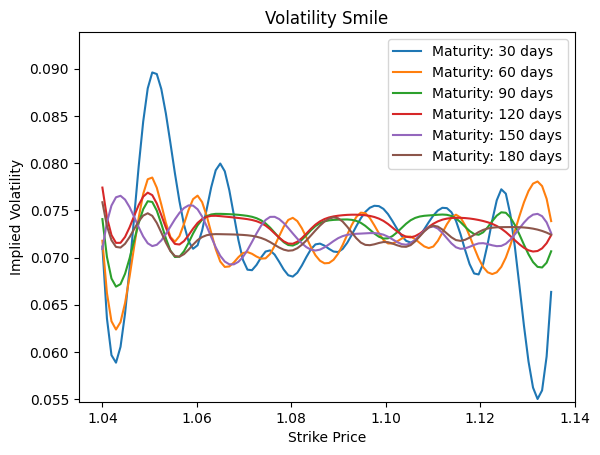

In [200]:
# Plotting Smile
plot_volatility_smile(implied_volatilities)

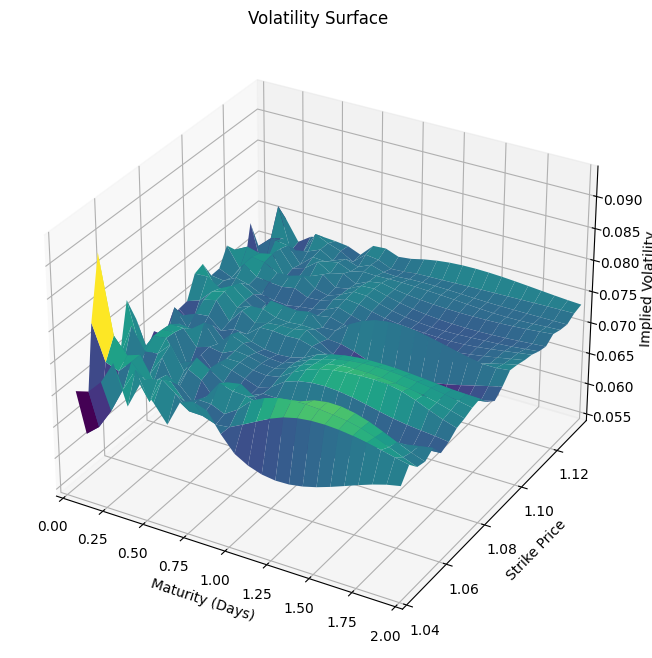

In [198]:
# Plotting Surface
plot_volatility_surface(implied_volatilities)